<a href="https://colab.research.google.com/github/Lyshen/PiggyToy/blob/main/Lesson05_VAE_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 5. Simple VAE excerise
1. Re-use lesson 3's code
2. Try to implement your simple VAE using the MNIST dataset
3. Explore some simple ideas about the generative model
4. Compare the results with Pytorch


In [22]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transform

In [23]:
tt = transform.Compose([transform.ToTensor()])

train_data = MNIST(root='./data', train=True, transform=tt, download=True)
test_data = MNIST(root='./data', train=False, transform=tt)

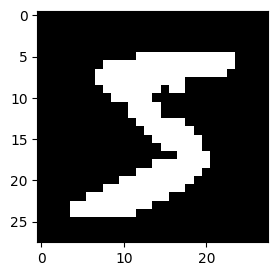

In [28]:
def transform_from_torch_to_numpy(torch_data):
    features_np = torch_data.data.numpy()
    labels_np = torch_data.targets.numpy()

    features_np = np.resize(features_np, (features_np.shape[0], features_np.shape[1] * features_np.shape[2]))

    # Simplify the exercise
    features_np[features_np != 0] = 1

    labels = np.zeros((labels_np.shape[0], 10))
    for i in range(10):
        labels[labels_np==i, i] = 1.

    return features_np, labels

train_features, train_labels = transform_from_torch_to_numpy(train_data)
test_features, test_labels = transform_from_torch_to_numpy(test_data)

import matplotlib.pyplot as plt
figure = plt.figure(figsize=(3, 3))
x = np.resize(train_features[0], (28, 28))
plt.imshow(x, cmap='gray')
plt.show()

In [29]:
def shuffle_dataset(n, batch_size):
    idices= np.array(range(n))
    np.random.shuffle(idices)
    batch_sample_size = int((n - n % batch_size) / batch_size)
    m = int(batch_size * batch_sample_size)
    a = idices[0:m].reshape((batch_size, batch_sample_size))
    b = idices[m:].reshape((1, n % batch_size))
    return a

def get_precision(predict, y):
    a = np.argmax(predict, axis=1)
    b = np.argmax(y, axis=1)
    print(np.sum(a == b) / y.shape[0])

In [30]:
# Re implement simple DNN
sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))

# array / vector  very carefully
softmax = lambda a: np.exp(a) / (np.sum(np.exp(a), axis=1)[:, np.newaxis])

class Linear:
    def __init__(self, in_size, out_size = 1):
        self.in_size = in_size + 1
        self.out_size = out_size
        self.X = None
        self.W = np.random.uniform(-1., 1., size=(self.in_size, self.out_size))
        self.dL_by_dW = None

    def forward(self, X):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = self.X.dot(self.W)
        return Z

    def backward(self, dL_by_dZ):
        m = dL_by_dZ.shape[0]
        # Matrix Z = XW   X(m, n+1) W(n+1, out) Z(m, out)
        # dL/dZ = (m, out) dZ/dX = W.T  (out, n+1)  dZ/dW = X.T (n+1, m)
        # dL/dW = dZ/dW * dL/dZ  (n+1, out)
        # dL/dX = dL/dZ * dZ/dX  (m, n+1)

        # backward dL/dX and record dL/dW
        dZ_by_dW = self.X.T  #(n+1, m)
        dZ_by_dX = self.W.T  #(out, n+1)
        dL_by_dX = dL_by_dZ.dot(dZ_by_dX) #(m, n+1)
        #dZ/dW = X.T (n+1, m) .dot dL/dZ = (m, out)
        self.dL_by_dW = dZ_by_dW.dot(dL_by_dZ) / m #(n+1, out)
        return dL_by_dX[:, :-1]

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = X.dot(self.W)
        return Z

    def update_weights(self, learning_rate):
        self.W = self.W - self.dL_by_dW * learning_rate


class Sigmoid_Active_Function:
    def __init__(self):
        self.active_function = sigmoid
        self.H = None

    def forward(self, X):
        self.H = self.active_function(X)
        return self.H

    def backward(self, up_gradient):
        self.local_gradient = (1 - self.H) * self.H
        down_gradient = up_gradient * self.local_gradient
        return down_gradient

    def predict(self, X):
        H = self.active_function(X)
        return H

    def update_weights(self, learning_rate):
        return

class Cross_Entropy_Loss:
    def __init__(self):
        self.process_function = softmax

    def forward(self, Z, Y):
        #self.Y_hat = self.process_function(Z)
        self.Y_hat = Z
        #print(self.Y_hat[0])
        self.loss = -1. * np.sum(Y * np.log(self.Y_hat, where= self.Y_hat != 0)) #KL divergence
        #print(self.loss)
        return self.Y_hat, self.loss

    def backward(self, Y):
        # Math provement
        self.dL_by_dZ = self.Y_hat - Y
        return self.dL_by_dZ

class Operator_Packager:
    def __init__(self, operator_list):
        self.operator_list = operator_list

    def forward(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].forward(Z)
        return Z

    def backward(self, E):
        d = E
        size = len(self.operator_list)
        for i in range(size):
            index = size - 1 - i
            d = self.operator_list[index].backward(d)
        return d

    def predict(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].predict(Z)
        #Y_hat = softmax(Z)
        Y_hat = Z
        return Y_hat

    def update_weights(self, learning_rate):
        size = len(self.operator_list)
        for i in range(size):
            self.operator_list[i].update_weights(learning_rate)


In [36]:
class VAE:
    def __init__(self, size_of_features, size_of_bottle):
        self.model = Operator_Packager([
            Linear(size_of_features, 100),
            Sigmoid_Active_Function(),
            Linear(100, 50),
            Sigmoid_Active_Function(),
            Linear(50, size_of_bottle),
            Linear(size_of_bottle, 50),
            Sigmoid_Active_Function(),
            Linear(50, 100),
            Sigmoid_Active_Function(),
            Linear(100, size_of_features),
            Sigmoid_Active_Function()
        ])
        self.bottle_layer = 3

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        Y = self.model.predict(X)
        return Y

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

    def encode(self, X):
        Z = X
        for i in range(self.bottle_layer):
            Z = self.model.operator_list[i].predict(Z)
        return Z

    def decode(self, Z):
        X = Z
        for i in range(self.bottle_layer, len(self.model.operator_list)):
            X = self.model.operator_list[i].predict(X)
        return X

Epoch 1
-------------------------------


<ipython-input-30-a9de973eb501>:2: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))


t: 1  loss : 806504.2882050275


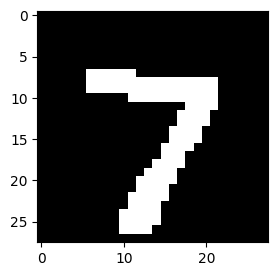

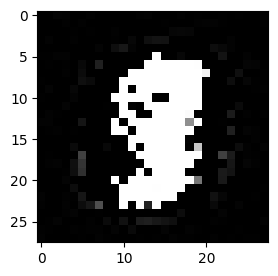

t: 2  loss : 756498.7314446381
t: 3  loss : 721344.6631958071
t: 4  loss : 673079.3991316344
t: 5  loss : 655249.2648019714
t: 6  loss : 627687.4449108017
t: 7  loss : 627282.5377366787
t: 8  loss : 580085.6151037234
t: 9  loss : 565636.9319733912
t: 10  loss : 574604.8437497246
Epoch 11
-------------------------------
t: 11  loss : 558389.6199434838
t: 12  loss : 554892.0642827125
t: 13  loss : 565514.2157653398
t: 14  loss : 514755.9081810318
t: 15  loss : 509051.2025464524
t: 16  loss : 505732.83577826404
t: 17  loss : 517741.3746578655
t: 18  loss : 509768.7066737551
t: 19  loss : 492278.08979077725
t: 20  loss : 507015.86851263547
Epoch 21
-------------------------------
t: 21  loss : 499439.3937700051
t: 22  loss : 481874.8999349138
t: 23  loss : 503426.8458941773
t: 24  loss : 524586.0531074759
t: 25  loss : 525375.2141624619
t: 26  loss : 489489.49088752596
t: 27  loss : 474641.3261750381
t: 28  loss : 475500.3956300059
t: 29  loss : 455353.411226565
t: 30  loss : 453741.489941

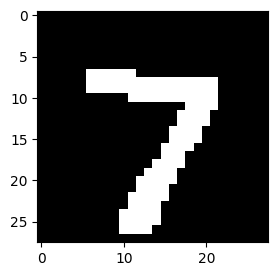

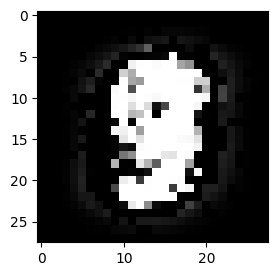

t: 53  loss : 401776.2856934735
t: 54  loss : 410868.9768970811
t: 55  loss : 391024.36010101705
t: 56  loss : 380461.5519483699
t: 57  loss : 337481.30880619935
t: 58  loss : 356552.08242176677
t: 59  loss : 371997.79414415086
t: 60  loss : 360787.3675398923
Epoch 61
-------------------------------
t: 61  loss : 353133.3432978254
t: 62  loss : 337600.2232894841
t: 63  loss : 352728.5220521769
t: 64  loss : 343553.1827200631
t: 65  loss : 326745.4929888188
t: 66  loss : 306730.22010415833
t: 67  loss : 292344.36676823534
t: 68  loss : 315033.88202793425
t: 69  loss : 296833.52056338097
t: 70  loss : 306641.8665749533
Epoch 71
-------------------------------
t: 71  loss : 302581.4190447806
t: 72  loss : 299280.04055976926
t: 73  loss : 301522.01112307573
t: 74  loss : 304483.7545064882
t: 75  loss : 294714.33330048464
t: 76  loss : 296389.35992576444
t: 77  loss : 292326.45303518826
t: 78  loss : 289964.9323528395
t: 79  loss : 314858.2854430358
t: 80  loss : 278157.2126308047
Epoch 81


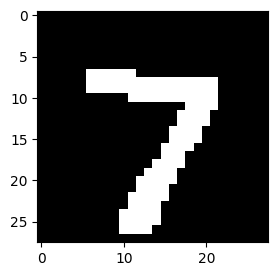

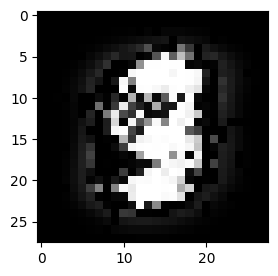

t: 104  loss : 279534.30097332975
t: 105  loss : 293550.39469991915
t: 106  loss : 296302.7648252439
t: 107  loss : 281293.5848360957


KeyboardInterrupt: ignored

In [37]:
demo_vae = VAE(28*28, 32)
loss = Cross_Entropy_Loss()

epochs = 200
m = train_labels.shape[0]

for t in range(epochs):
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    batch_size = 60
    batch_matrix = shuffle_dataset(m, batch_size)

    l = 0.
    for batch_id in range(batch_size):
        batch_index = batch_matrix[batch_id, :]
        X = train_features[batch_index, :]
        Y = train_features[batch_index, :]

        Z = demo_vae.forward(X)
        #print(Z.shape)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_vae.backward(dL_by_dZ)

        demo_vae.update_weights(learning_rate = 10.)

    print('t:', t+1, ' loss :', l)

    if (t % 51 == 0):
        X = test_features
        Y = demo_vae.predict(X)
        encode1 = np.resize(X[0], (28, 28))
        decode1 = np.resize(Y[0], (28, 28))

        figure = plt.figure(figsize=(3, 3))
        plt.imshow(encode1, cmap='gray')
        plt.show()

        figure = plt.figure(figsize=(3, 3))
        plt.imshow(decode1, cmap='gray')
        plt.show()